In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Process Model

In [2]:
# give an example here first
v_sb_b = np.array([2, 2, 0])
w_sb_b = np.array([0, 0, 3])
bp = np.array([2, 1, 0])

In [3]:
v_bpc_b = np.zeros((3,))
v_bpc_b

array([0., 0., 0.])

$$
v_{bp_c}^b=-v_{sb}^b+-w_{sb}^b\times b_p = -\begin{bmatrix}
 \mathbf{I} & \left [ \mathbf{p_c} \right ] 
\end{bmatrix}\begin{bmatrix}
v_{sb}^b \\ w_{sb}^b
\end{bmatrix}
$$

Direct cross product

In [37]:
v_bpc_b = -v_sb_b + -np.cross(w_sb_b, bp)
v_bpc_b

array([ 1, -8,  0])

skew-symmetric matrix 

In [5]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )


np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [38]:
I = np.identity(3)
pc_ = -skew(bp)  # should be negative
B = -np.append(I, pc_, axis=1)
xi = np.append(v_sb_b, w_sb_b, axis=0)
xi, B

(array([2, 2, 0, 0, 0, 3]),
 array([[-1., -0., -0., -0., -0.,  1.],
        [-0., -1., -0., -0., -0., -2.],
        [-0., -0., -1., -1.,  2., -0.]]))

In [7]:
B @ xi

array([ 1., -8.,  0.])

WHYYYYYYYYY!!!!

$$
    \mathbf{a} \times \mathbf{b} = - \left ( \mathbf{b} \times \mathbf{a} \right ) 
$$

In [40]:
def cal_vbpc_dot(x, lv, av):
    xi = np.append(lv, av, axis=0)
    B = -np.append(np.identity(3), -skew(x), axis=1)
    return B @ xi

In [39]:
def cal_vbpc_cross(x, lv, av):
    # v_bpc_b = -v_sb_b + -np.cross(w_sb_b, bp)
    return -lv + -np.cross(av, x)

In [44]:
tmp = np.array([1, 1, 0])
cal_vbpc_dot(tmp, np.array([2, 2, 0]), np.array([0, 0, 0]))
# cal_vbpc_cross(tmp, v_sb_b, w_sb_b)

array([-2., -2.,  0.])

State transition function

In [8]:
def f_contact(x, lv, av, dt):
    input = np.append(lv, av, axis=0)
    B = -dt * np.append(np.identity(3), -skew(x), axis=1)
    A = np.identity(3)
    prior_predict = A @ x + B @ input
    return prior_predict

In [45]:
f_contact(np.array([1, 1, 0]), np.array([2, 2, 0]), np.array([0, 0, 0]), dt=1)

array([-1., -1.,  0.])

### Measurement Model

5-order bivariate polynomial model

In [10]:
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y, copy=False)  # meshgrid ? dimension to 400
X, X.shape

(array([[0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
        [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
        [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
         0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ],
        [0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
         0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
         0.52631579, 0.57894737

In [11]:
Z = X**2 + Y**2 + np.random.rand(*X.shape) * 0.01

X = X.flatten()
Y = Y.flatten()

A = np.array(
    [X * 0 + 1, X, Y, X**2, X**2 * Y, X**2 * Y**2, Y**2, X * Y**2, X * Y]
).T
B = Z.flatten()

coeff, r, rank, s = np.linalg.lstsq(A, B, rcond=None)

In [12]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [18]:
import pandas as pd

In [20]:
dataframe = pd.read_excel("FullRangeData.xlsx", sheet_name="Formated_MannulyFixed")
dataframe

,X,Y,Z
0,10,115,3.998222
1,15,115,3.686222
2,20,115,3.374222
3,25,115,3.062222
4,30,115,2.730000
...,...,...,...
165,70,160,-6.110000
166,75,160,-6.095555
167,80,160,-5.936666
168,85,160,-5.618889


In [21]:
z = np.array(dataframe)[:, 2]
z, z.shape

(array([ 3.99822213,  3.68622213,  3.37422214,  3.06222214,  2.72999997,
         2.46999984,  2.12333332,  1.80555549,  1.50944439,  1.19888884,
         0.88111108,  0.51999998,  0.2311111 , -0.07222222, -0.40588887,
        -0.72511108, -1.0443333 ,  4.05586227,  3.77192578,  3.42333317,
         3.17777771,  3.01888874,  2.68666659,  2.38333323,  1.97888882,
         1.55999994,  1.12666663,  0.75111108,  0.31777777,  0.01444444,
        -0.33222221, -0.53444442, -0.86666663, -1.24634916,  4.20539674,
         3.78444441,  3.68333321,  3.42333317,  3.22111109,  2.91777762,
         2.51333316,  2.15222218,  1.57444439,  1.11222218,  0.63555553,
         0.11555555, -0.25999999, -0.66444442, -0.98222219, -1.19888884,
        -1.32888884,  4.21777768,  4.11666648,  4.02999976,  3.76999995,
         3.55333315,  3.23555552,  2.8166666 ,  2.31111105,  1.52388883,
         1.03999996,  0.44777776, -0.15888888, -0.60666664, -1.05444441,
        -1.45888884, -1.55999994, -1.80555549,  4.6

In [22]:
x = np.linspace(10, 90, 17)
y = np.linspace(115, 160, 10)
X, Y = np.meshgrid(x, y)
X.shape

(10, 17)

In [23]:
coeff, r, rank, s = polyfit2d(x, y, z)

(170, 36) (170,)


In [24]:
coeff.shape

(36,)

(17, 10)


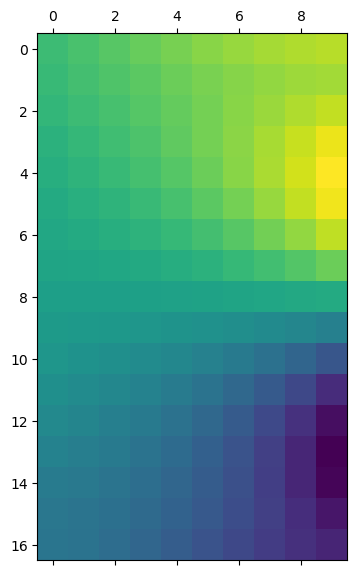

In [25]:
fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((6, 6)))
print(fitted_surf.shape)
plt.matshow(fitted_surf)

RMSE

In [26]:
fitted_surf, fitted_surf.shape

(array([[ 3.35594568,  3.75343317,  4.15676144,  4.55872051,  4.95088149,
          5.32352467,  5.66556742,  5.96449227,  6.20627482,  6.3753118 ],
        [ 3.20562505,  3.56509503,  3.92873682,  4.29027158,  4.64239371,
          4.97671111,  5.28368553,  5.55257281,  5.77136323,  5.92672175],
        [ 2.99477729,  3.34446337,  3.71260389,  4.09744418,  4.4968033 ,
          4.9080457 ,  5.32805284,  5.75319477,  6.17930183,  6.60163619],
        [ 2.76304906,  3.10215945,  3.477582  ,  3.89301339,  4.35239754,
          4.8599278 ,  5.42004921,  6.03746068,  6.71711725,  7.46423229],
        [ 2.53199172,  2.84282771,  3.20350558,  3.62226564,  4.10808968,
          4.67071673,  5.32065883,  6.06921679,  6.92849594,  7.91142187],
        [ 2.30875398,  2.56673935,  2.87959244,  3.25808872,  3.71388789,
          4.25953341,  4.90845189,  5.67495259,  6.57422682,  7.62234747],
        [ 2.08977468,  2.27139611,  2.503212  ,  2.79606169,  3.16136411,
          3.61106201,  4.1575662

In [27]:
z.reshape(10, 17).T

array([[ 3.99822213,  4.05586227,  4.20539674,  4.21777768,  4.62222205,
         4.92555523,  5.34444438,  5.69111088,  5.99444405,  6.39888875],
       [ 3.68622213,  3.77192578,  3.78444441,  4.11666648,  4.49222215,
         4.92555523,  5.3877777 ,  5.83555539,  6.25444423,  6.68777747],
       [ 3.37422214,  3.42333317,  3.68333321,  4.02999976,  4.40555551,
         4.86777751,  5.41666667,  5.83555545,  6.44222217,  6.97666634],
       [ 3.06222214,  3.17777771,  3.42333317,  3.76999995,  4.2755555 ,
         4.75222211,  5.31555547,  5.92222193,  6.49999984,  7.10666625],
       [ 2.72999997,  3.01888874,  3.22111109,  3.55333315,  4.00111095,
         4.46333318,  5.17111089,  5.76333316,  6.48555549,  7.27999973],
       [ 2.46999984,  2.68666659,  2.91777762,  3.23555552,  3.62555541,
         4.13111093,  4.7233332 ,  5.51777765,  6.28333314,  7.25111082],
       [ 2.12333332,  2.38333323,  2.51333316,  2.8166666 ,  3.13444434,
         3.59666652,  4.1744443 ,  4.91111077

In [28]:
t1 = np.array([[2, 3], [1, 4]])
t2 = np.array([[1, 5], [2, 4]])
rms = np.sqrt(np.mean((t1 - t2) ** 2))

In [29]:
rms = np.sqrt(np.mean((z.reshape(10, 17).T - fitted_surf) ** 2))
print("RMS residual =", rms)

RMS residual = 0.23193393244515742


In [30]:
from sklearn.metrics import r2_score

r2_score(z.reshape(10, 17).T, fitted_surf)

0.9944280222772985

3D Plot

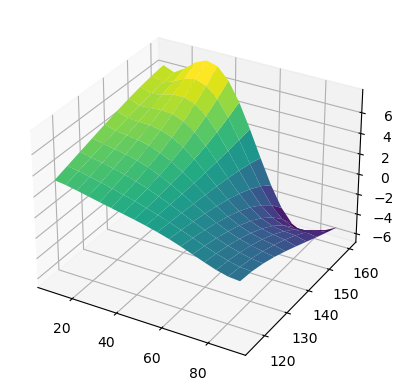

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(X, Y, fitted_surf.T, cmap="viridis")
# cset = ax.contourf(X, Y, Z-fitted_surf.T, zdir='z', offset=-4, cmap='viridis')
# ax.set_zlim(-4,np.max(fitted_surf))
plt.show()

### Use this measurement model to generate some synthesis data along a fake trajectory : add some noise into it manually

In [46]:
# Start point
X_start = 10
Y_start = 140

# End point
X_end = 90
Y_end = 140

np.linspace(X_start, X_end, 100)

array([10.        , 10.80808081, 11.61616162, 12.42424242, 13.23232323,
       14.04040404, 14.84848485, 15.65656566, 16.46464646, 17.27272727,
       18.08080808, 18.88888889, 19.6969697 , 20.50505051, 21.31313131,
       22.12121212, 22.92929293, 23.73737374, 24.54545455, 25.35353535,
       26.16161616, 26.96969697, 27.77777778, 28.58585859, 29.39393939,
       30.2020202 , 31.01010101, 31.81818182, 32.62626263, 33.43434343,
       34.24242424, 35.05050505, 35.85858586, 36.66666667, 37.47474747,
       38.28282828, 39.09090909, 39.8989899 , 40.70707071, 41.51515152,
       42.32323232, 43.13131313, 43.93939394, 44.74747475, 45.55555556,
       46.36363636, 47.17171717, 47.97979798, 48.78787879, 49.5959596 ,
       50.4040404 , 51.21212121, 52.02020202, 52.82828283, 53.63636364,
       54.44444444, 55.25252525, 56.06060606, 56.86868687, 57.67676768,
       58.48484848, 59.29292929, 60.1010101 , 60.90909091, 61.71717172,
       62.52525253, 63.33333333, 64.14141414, 64.94949495, 65.75

In [47]:
val = np.polynomial.polynomial.polygrid2d(X_start, Y_start, coeff.reshape((6, 6)))
val

5.323524665875066

In [49]:
trajecotry_ = np.polynomial.polynomial.polygrid2d(
    np.linspace(X_start, X_end, 160),
    140,
    coeff.reshape((6, 6)),
)
trajecotry_, trajecotry_.shape

(array([ 5.32352467e+00,  5.26641952e+00,  5.21532970e+00,  5.16983817e+00,
         5.12954056e+00,  5.09404496e+00,  5.06297181e+00,  5.03595370e+00,
         5.01263525e+00,  4.99267295e+00,  4.97573497e+00,  4.96150104e+00,
         4.94966226e+00,  4.93992099e+00,  4.93199064e+00,  4.92559554e+00,
         4.92047081e+00,  4.91636213e+00,  4.91302565e+00,  4.91022783e+00,
         4.90774522e+00,  4.90536439e+00,  4.90288170e+00,  4.90010318e+00,
         4.89684438e+00,  4.89293019e+00,  4.88819468e+00,  4.88248098e+00,
         4.87564109e+00,  4.86753572e+00,  4.85803417e+00,  4.84701412e+00,
         4.83436152e+00,  4.81997041e+00,  4.80374278e+00,  4.78558837e+00,
         4.76542459e+00,  4.74317628e+00,  4.71877561e+00,  4.69216188e+00,
         4.66328143e+00,  4.63208741e+00,  4.59853964e+00,  4.56260451e+00,
         4.52425475e+00,  4.48346930e+00,  4.44023317e+00,  4.39453728e+00,
         4.34637825e+00,  4.29575834e+00,  4.24268520e+00,  4.18717176e+00,
         4.1

Fictitious measurement noise

In [50]:
# measurement standard deviation, np.sqrt(variance)

z_std = 1.0

In [51]:
from numpy.random import randn

trajecotry_p = (
    trajecotry_
    + randn(
        160,
    )
    * z_std
)

Fictitious control input : linear and angular vel

In [ ]:
lv = np.array([0.5, 0, 0])
av = np.array([0, 0, 0])

Process and Measurement Noise

In [56]:
# Measurement Noise
R = np.array([[rms**2]])
R, rms

(array([[0.05379335]]), 0.23193393244515742)

In [59]:
# Process Noise
from filterpy.common import Q_discrete_white_noise

# Q_discrete_white_noise(dim=2, dt=1., var=.001)

# X- and Y- coordinate is independant therefore, 
Q = np.array([[.001, 0], [0, .001]])
Q

array([[0.001, 0.   ],
       [0.   , 0.001]])